In [203]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 读取数据集

## 实现数据集读取函数

In [60]:
def loadDataSet(filePath):
    '''数据集读取函数'''
    data, label = [], []
    # 读取数据集
    with open(filePath) as f:
        for line in f.readlines():
            temp = line.strip().split(",")
            data.append([float(i) for i in temp[:-1]])
            if temp[-1] != '?':
                temp[-1] = float(temp[-1])
            label.append(temp[-1])
    #####输出数据集相关信息##########
    print("data dimension of dataset：", len(data[0]))
    print("number of training data :", len(data))
    print("label frequency:", dict(Counter(label)))
    #####输出数据集相关信息##########
    return data, label

## 读取训练集、验证集、测试集

In [61]:
trainSet, trainSet_label = loadDataSet(".\\data\\train.csv")

data dimension of dataset： 65
number of training data : 4000
label frequency: {1.0: 626, -1.0: 3374}


In [62]:
validateSet, validateSet_label = loadDataSet(".\\data\\validate.csv")

data dimension of dataset： 65
number of training data : 1000
label frequency: {1.0: 160, -1.0: 840}


In [63]:
testSet, _ = loadDataSet(".\\data\\test.csv")

data dimension of dataset： 65
number of training data : 1000
label frequency: {'?': 1000}


从输出的信息可以看到，三个数据集的数据维度都是65，其中训练集和验证集的标签值只有+1和-1，符合感知器算法的数据要求，并且可以发现-1的标记在两个数据集中都占有较大的比重。

# 评测指标

## 原理介绍

对于二元分类，有

```
--------------------
TP：本来为+1，预测为+1
FN：本来为+1，预测为-1
TN：本来为-1，预测为-1
FP：本来为-1，预测为+1
---------------------
```
	
其中字母和对应意义为： T：True, F：False, N：negative, P：positive。

准确率Accuracy为：$\frac{TP+TN}{TP+TN+FP+FN}$，从字面上看就是：**【所有样本】中被预测【对】的样本的百分比**

召回率Recall为：$\frac{TP}{TP+FN}$，从字面上看就是：**【所有本是正分类的样本】中被预测【对】的百分比**

精确率Precision为：$\frac{TP}{TP+FP}$，从字面上看就是：**【所有被分类为正的样本】中被预测【对】的百分比**

F1值为： $$\frac{2*Precision*Recall}{Precision+Recall}=\frac{2*TP}{2*TP+FN+FP} $$

至于这4个指标的实际意义，在思考题中会详细解释。

## 函数实现及简单测试

In [244]:
def evaluation(outLabel, realLabel, printRes=True):
    '''给定算法得到的分类结果和实际的分类结果，计算评测指标'''
    def safeDivide(a, b):
        '''子函数：当分母为0时返回除式结果为 -1'''
        return -1 if b == 0 else a/b
    
    TP, FN, TN, FP = 0, 0, 0, 0
    #计算TP, FN, TN, FP
    for index, label in enumerate(outLabel):
        if label == 1:
            if realLabel[index] == 1:
                TP += 1
            else:
                FN += 1
        else:
            if realLabel[index] == 1:
                FP += 1
            else:
                TN += 1
    ###########计算4种评测指标###########
    accuracy = safeDivide(TP+TN, TP+TN+FP+FN)
    recall = safeDivide(TP, TP+FN)
    precision = safeDivide(TP, TP+FP)
    F1 = safeDivide(2*TP, 2*TP+FN+FP)
    ###########计算4种评测指标###########
    ans = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'F1':F1}
    if printRes:
        print("Accuracy: %.5f  Recall: %.5f" % (accuracy, recall))
        print("Precision: %.5f F1: %.5f" % (precision, F1))
    return ans

print('test 1: normal one')
evaluation([1,1,-1,-1],[1,-1,1,-1])
print('\ntest 2: may have zero division error')
evaluation([-1,-1,-1,-1],[1,-1,1,-1])

test 1: normal one
Accuracy: 0.50000  Recall: 0.50000
Precision: 0.50000 F1: 0.50000

test 2: may have zero division error
Accuracy: 0.50000  Recall: -1.00000
Precision: 0.00000 F1: 0.00000


评测指标函数实现中需要注意的一点是：计算指标的公式中包含除式，因此需要考虑分母为0的异常情况，这里将分母为0时的计算式的结果设置为-1。

# 原始感知器算法

## 算法伪代码

```
PLA_origin(w0, theta, trainSet, label, maxRunTimes)

算法功能：
------------------------------------
原始的感知器算法实现
------------------------------------

输入数据：
------------------------------------
w0:参数 w 的给定初始值
theta:模型中的阈值
trainSet:训练集
label:训练集对应的标签
maxRunTimes:算法中的迭代次数
------------------------------------

输出数据：
------------------------------------
w:根据训练集预测的划分数据集超平面的法向量
------------------------------------

算法流程：
------------------------------------
0.根据w0和theta得到参数 w 的初始值
1.给训练集trainSet中的每一个样本前加一个常数1
2.当迭代次数小于maxRunTimes时：
2.1.遍历训练集中的所有样本：
2.1.1.更新预测错误的样本
------------------------------------
```

## 算法实现及简单测试

这里选择用如下类来实现该算法，其中最为重要的是如下两个函数：

- fit函数:根据训练集+标签+最大迭代次数来得到模型参数 w
- apply函数：根据fit函数得到的 w 来对其他数据集进行二分类

In [66]:
class PLA_origin:
    
    def __init__(self, w0, theta=0):
        '''初始化变量'''
        self.w = np.array([theta]+w0, dtype='float64')
    
    def __addOne2Samples(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        dataSet = np.array(dataSet)
        return np.column_stack((ones, dataSet))
    
    def fit(self, trainSet, label, maxRunTimes=100):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        label = np.array(label, dtype='float64')
        #给每一个样本前加一个常数1
        trainSet = self.__addOne2Samples(trainSet)
        cnt = 1
        while cnt <= maxRunTimes:
            cnt += 1
            #遍历所有样本
            for index, sample in enumerate(trainSet):
                #更新预测错误的样本
                if np.sign(np.dot(sample, self.w)) != label[index]:
                    self.w += label[index]*sample
                    
    def apply(self, otherSet):
        '''根据已训练出的 w 对其他数据集进行划分'''
        otherSet = self.__addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = np.sign(np.dot(sample, self.w))
        return outputLabel
    
    def getW(self):
        return self.w

############测试程序###################
a = [[-4, -1], [0, 3]] # trainSet
b = [1,-1]             # label
c = [1, 1]             # w0
d = 1                  # theta
e = [[-2, 3]]          # otherSet

p = PLA_origin(w0=c, theta=d) # 得到PLA类
p.fit(a, b, maxRunTimes=10)      # 给定的训练集和标签，训练PLA的参数 w
print("最终训练得到的参数 w 为：", p.getW())  
print("对测试数据集 %s 划分的结果为： %s " %(e, p.apply(e)))
############测试程序###################

最终训练得到的参数 w 为： [ 1. -3. -3.]
对测试数据集 [[-2, 3]] 划分的结果为： [-1.] 


---

下面根据测试数据以及输出来验证算法实现的正确性。

首先，给定的训练集为a，a中有两个样本数据：[-4, -1]和[0, 3]，从b可知两者对应的分类标签为+1和-1。

初始设置w0全为1，阈值 $\theta$ 设置为1。

那么在样本的第一个维度插入1后，即有：

```
***********************************************
      训练集                      测试集          
----------------------------   --------------  
     样本           标签            样本
x1 = [1, -4, -1]  |  y1 = +1   x3 = [1, -2, 3]
x1 = [1,  0,  3]  |  y2 = -1

PLA算法参数 w 初始设置为： [1, 1, 1]
***********************************************
```

step 1: 

$sign(w^Tx_1)=sign(1-4-1)=-1 \not = y_1$ ---> 样本x1分类错误

更新 w 得$w=w+y_1x_1=[2, -3, 0]$

step 2:

$sign(w^Tx_2)=sign(2+0+0)=+1 \not = y_2$ ---> 样本x2分类错误

更新 w 得$w=w+y_2x_2=[1,-3,-3]$

step 3:

遍历数据集中的两个样本，得： $sign(w^Tx_1)= y_1$ 和 $sign(w^Tx_2)= y_2$，算法停止迭代。

step 4:

计算 $sign(w^Tx_3)= sign(1+6-9)=-1$，因此测试集中的唯一一个样本的预测分类为-1。

对比最终训练得到的w和x3的分类结果，程序输出与其相符，因此算法实现正确。

## 应用算法到验证集上调参

这里根据训练集训练算法，并在验证集上进行调参。

调参思路：由于原始的PLA算法实现中有涉及到【迭代次数】这个参数的设置，而给定一个【迭代次数】，最终所得的算法结果在【每次运行都是一样的】，因此将算法应用在验证集上，得到F1值最高时的【迭代次数】。

In [208]:
maxRangeEnd = 150
testRange = list(range(maxRangeEnd))
accuracys, recalls, precisions, F1s = [], [], [], []
for runTime in testRange:
    ############应用 PLA 算法###############
    pla = PLA_origin(w0=[1]*len(trainSet[0]), theta=1)     #得到 PLA分类器实例
    pla.fit(trainSet, trainSet_label, maxRunTimes=runTime) #根据训练集训练参数 w
    ansLabel = pla.apply(validateSet)                      #在验证集上应用分类器
    temp = evaluation(ansLabel, validateSet_label, False)  #得到评测指标
    ############应用 PLA 算法###############
    #保存 4 个指标的值，供后续绘图
    accuracys.append(temp['accuracy'])
    recalls.append(temp['recall'])
    precisions.append(temp['precision'])
    F1s.append(temp['F1'])

下面来输出4种指标达到的最大值以及对应的运行次数：

In [209]:
_ = (max(accuracys), testRange[np.argmax(accuracys)])
print("max accuracy is %.5f when run time is %d" % _)
_ = (max(recalls), testRange[np.argmax(recalls)])
print("max recall is %.5f when run time is %d" % _)
_ = (max(precisions), testRange[np.argmax(precisions)])
print("max precisions is %.5f when run time is %d" % _)
runTime_with_bestF1 = testRange[np.argmax(F1s)]
_ = (max(F1s), runTime_with_bestF1)
print("max F1 is %.5f when run time is %d" % _)

max accuracy is 0.84800 when run time is 145
max recall is 0.59091 when run time is 2
max precisions is 1.00000 when run time is 0
max F1 is 0.50495 when run time is 53


### 绘制评测结果随着运行时间的变化图

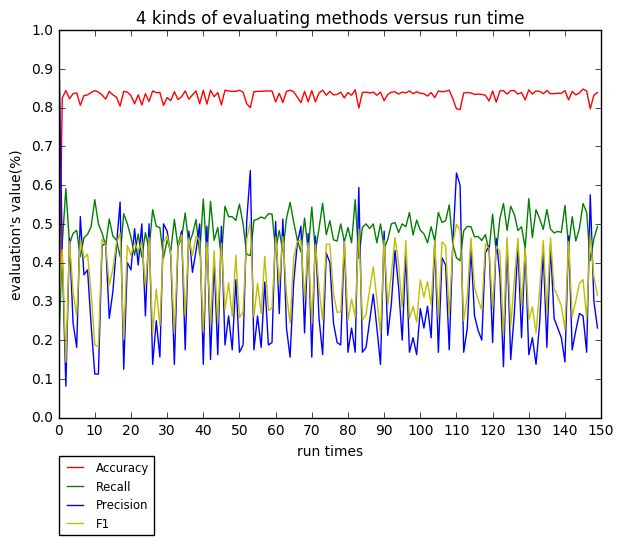

In [210]:
fig,ax = plt.subplots() 
fig.set_size_inches(7, 5)
plt.plot(testRange, accuracys, 'r', label='Accuracy')
plt.plot(testRange, recalls,'g', label='Recall')
plt.plot(testRange, precisions,'b', label='Precision')
plt.plot(testRange, F1s,'y', label='F1')
ax.set_xlim(0,maxRangeEnd)
ax.set_xticks(np.arange(0,maxRangeEnd+10,10))
ax.set_yticks(np.arange(0.,1.1,0.1))
plt.xlabel('run times')
plt.ylabel('evaluation\'s value(%)')
plt.title("4 kinds of evaluating methods versus run time")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
plt.show()
plt.close()

## 应用算法到测试集上

下面选取F1值最高时对应的run time来作为PLA算法的最优运行次数。

In [216]:
#得到最优的 PLA 分类器
pla = PLA_origin(w0=[1]*len(trainSet[0]), theta=1)
pla.fit(trainSet, trainSet_label, maxRunTimes=runTime_with_bestF1)

print('再次确认该分类器在验证集上的最优表现:')
ansLabel1 = pla.apply(validateSet)
print('标签分类分布：', dict(Counter(ansLabel1)))

#确保当前参数调出来的分类器是最优的
assert evaluation(ansLabel1, validateSet_label)['F1'] == max(F1s) 

print("\n确认无误，将该分类器应用在测试集上：")
ansLabel1 = pla.apply(testSet)
print('标签分类分布：', dict(Counter(ansLabel1)))

再次确认该分类器在验证集上的最优表现:
标签分类分布： {1.0: 244, -1.0: 756}
Accuracy: 0.80000  Recall: 0.41803
Precision: 0.63750 F1: 0.50495

确认无误，将该分类器应用在测试集上：
标签分类分布： {1.0: 232, -1.0: 768}


### 保存结果

经过上面的验证，将最优分类器应用在测试集上的效果保存到文件中。

In [214]:
outFileName = 'PLA_initial_15352220.csv'
with open(outFileName, 'w', encoding='utf-8') as f:
    for i in ansLabel1:
        f.write(str(i)+'\n')

#  口袋算法

## 算法伪代码

```
PLA_pocket(w0, theta, trainSet, label, maxRunTimes, method)

算法功能：
------------------------------------
感知器口袋算法实现
------------------------------------

输入数据：
------------------------------------
w0:参数 w 的给定初始值
theta:模型中的阈值
trainSet:训练集
label:训练集对应的标签
maxRunTimes:算法中的迭代次数
method:指定评测指标
------------------------------------

输出数据：
------------------------------------
w_best:根据训练集预测的划分数据集超平面的最优法向量
------------------------------------

算法流程：
------------------------------------
0.根据w0和theta得到参数 w 的初始值
1.给训练集trainSet中的每一个样本前加一个常数1
2.当迭代次数小于maxRunTimes时：
2.1.遍历训练集中的所有样本：
2.1.1.更新预测错误的样本
2.1.2.根据到当前 w 对训练集进行划分结果
2.1.3.将上一步的结果和label进行对比，得到指定评测指标
2.1.4.若当前评测指标值比上一次的值高：
2.1.4.1.更新全局最优的w为当前的w
------------------------------------
```

## 算法实现及简单测试

这里选择用如下类来实现该算法，其中最为重要的是如下两个函数：

- fit函数:根据训练集+标签+最大迭代次数来得到模型参数 w
- apply函数：根据fit函数得到的 w 来对其他数据集进行二分类

In [230]:
class PLA_pocket:
    
    def __init__(self, w0, theta=0, method='F1'):
        '''初始化变量'''
        self.w = np.array([theta]+w0, dtype='float64')
        self.w_best = self.w.copy()
        self.method = method   #用于指定更新最优 w 的评估指标
    
    def __addOne2Samples(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        dataSet = np.array(dataSet)
        return np.column_stack((ones, dataSet))
    
    def __apply2TrainSet(self, trainSet):
        '''根据当前的 w 对训练集进行划分，在计算评估值时调用'''
        outputLabel = np.zeros(trainSet.shape[0])
        for index, sample in enumerate(trainSet):
            outputLabel[index] = np.sign(np.dot(sample, self.w))
        return outputLabel
    
    def __calcEvaluation(self, trainSet, label):
        '''计算当前 w 的用指定指标评估的效果'''
        #得到当前 w 对训练集进行划分结果
        outputLabel_ = self.__apply2TrainSet(trainSet)
        #得到划分的评估效果
        evaluateAns = evaluation(outputLabel_, label, False)
        #返回指定评估结果
        return evaluateAns[self.method]
    
    def fit(self, trainSet, label, maxRunTimes=100):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        label = np.array(label, dtype='float64')
        #给每一个样本前加一个常数1
        trainSet = self.__addOne2Samples(trainSet)
        maxEvaluatioin = -0.1
        cnt = 1
        while cnt <= maxRunTimes:
            cnt += 1
            #遍历所有样本
            for index, sample in enumerate(trainSet):
                #更新预测错误的样本
                if np.sign(np.dot(sample, self.w)) != label[index]:
                    self.w += label[index]*sample
                    #若检查是否更新最优的 w 
                    currentEvaluatioin = self.__calcEvaluation(trainSet, label)
                    if currentEvaluatioin > maxEvaluatioin:
                        self.w_best = self.w.copy()
                        maxEvaluatioin = currentEvaluatioin
                        
    def apply(self, otherSet):
        '''根据已训练出最优的 w 对其他数据集进行划分'''
        otherSet = self.__addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = np.sign(np.dot(sample, self.w_best))
        return outputLabel
    
    def getW(self):
        return self.w_best

############测试程序###################
a = [[-4, -1], [0, 3]] # trainSet
b = [1,-1]             # label
c = [1, 1]             # w0
d = 1                  # theta
e = [[-2, 3]]          # otherSet

p = PLA_pocket(w0=c, theta=d)    # 得到PLA类
p.fit(a, b, maxRunTimes=10)      # 给定的训练集和标签，训练PLA的参数 w
print("最终训练得到的参数 w 为：", p.getW())  
print("对测试数据集 %s 划分的结果为： %s " %(e, p.apply(e)))
############测试程序###################

最终训练得到的参数 w 为： [ 1. -3. -3.]
对测试数据集 [[-2, 3]] 划分的结果为： [-1.] 


## 应用算法到训练集和验证集上

In [234]:
maxRangeEnd2 = 20
testRange2 = list(range(maxRangeEnd2))
accuracys2, recalls2, precisions2, F1s2 = [], [], [], []
for runTime in testRange2:
    ############应用 PLA 算法###############
    pla2 = PLA_pocket(w0=[1]*len(trainSet[0]), theta=1) #得到 PLA分类器实例
    pla2.fit(trainSet, trainSet_label, maxRunTimes=runTime) #根据训练集训练参数 w
    ansLabel = pla2.apply(validateSet)                     #在验证集上应用分类器
    temp = evaluation(ansLabel, validateSet_label, False)  #得到评测指标
    ############应用 PLA 算法###############
    #保存 4 个指标的值，供后续绘图
    accuracys2.append(temp['accuracy'])
    recalls2.append(temp['recall'])
    precisions2.append(temp['precision'])
    F1s2.append(temp['F1'])

下面来输出4种指标达到的最大值以及对应的运行次数：

In [245]:
_ = (max(accuracys2), testRange2[np.argmax(accuracys2)])
print("max accuracy is %.5f when run time is %d" % _)
_ = (max(recalls2), testRange2[np.argmax(recalls2)])
print("max recall is %.5f when run time is %d" % _)
_ = (max(precisions2), testRange2[np.argmax(precisions2)])
print("max precisions is %.5f when run time is %d" % _)
runTime_with_bestF1_ = testRange2[np.argmax(F1s2)]
_ = (max(F1s2), runTime_with_bestF1_)
print("max F1 is %.5f when run time is %d" % _)

max accuracy is 0.82500 when run time is 1
max recall is 0.44966 when run time is 1
max precisions is 1.00000 when run time is 0
max F1 is 0.51306 when run time is 8


### 绘制评测结果随着运行时间的变化图

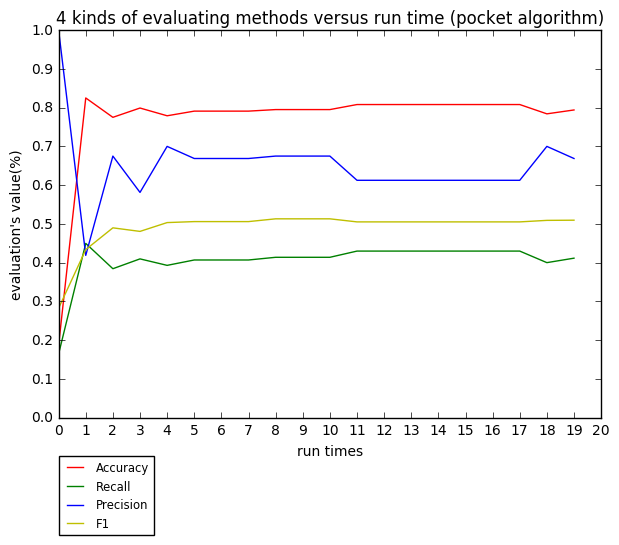

In [246]:
fig,ax = plt.subplots() 
fig.set_size_inches(7, 5)
plt.plot(testRange2, accuracys2, 'r', label='Accuracy')
plt.plot(testRange2, recalls2,'g', label='Recall')
plt.plot(testRange2, precisions2,'b', label='Precision')
plt.plot(testRange2, F1s2,'y', label='F1')
ax.set_xlim(0, maxRangeEnd2)
ax.set_xticks(np.arange(0,maxRangeEnd2+1,1))
ax.set_yticks(np.arange(0.,1.1,0.1))
plt.xlabel('run times')
plt.ylabel('evaluation\'s value(%)')
plt.title("4 kinds of evaluating methods versus run time (pocket algorithm)")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.,fontsize='small')
plt.show()
plt.close()

## 应用算法到测试集上

In [243]:
#得到最优的 PLA 分类器
pla2 = PLA_pocket(w0=[1]*len(trainSet[0]), theta=1)
pla2.fit(trainSet, trainSet_label, maxRunTimes=runTime_with_bestF1_)

print('再次确认该分类器在验证集上的最优表现:')
ansLabel2 = pla2.apply(validateSet)
print('标签分类分布：', dict(Counter(ansLabel2)))

#确保当前参数调出来的分类器是最优的
assert evaluation(ansLabel2, validateSet_label)['F1'] == max(F1s2)

print("\n确认无误，将该分类器应用在测试集上：")
ansLabel2 = pla2.apply(testSet)
print('标签分类分布：', dict(Counter(ansLabel2)))

再次确认该分类器在验证集上的最优表现:
标签分类分布： {1.0: 261, -1.0: 739}
Accuracy: 0.79500  Recall: 0.41379
Precision: 0.67500 F1: 0.51306

确认无误，将该分类器应用在测试集上：
标签分类分布： {1.0: 262, -1.0: 738}


### 保存结果

经过上面的验证，将最优分类器应用在测试集上的效果保存到文件中。

In [247]:
outFileName = 'PLA_pocket_15352220.csv'
with open(outFileName, 'w', encoding='utf-8') as f:
    for i in ansLabel2:
        f.write(str(i)+'\n')

# 思考题

- 有什么其他的手段可以解决数据集非线性可分的问题？

    - 答：通过某种方法将低维度的线性不可分的数据映射到高维空间中，在高维空间中可实现“线性可分”，比如使用SVM算法。
    
    
- 请查询相关资料，解释为什么要用准确率、精确率、召回率、F1值这四种评测算法效果的指标，其各自的意义是什么？

    - 答：首先来回顾下这4个指标的定义：
    
    准确率Accuracy为：$$\frac{TP+TN}{TP+TN+FP+FN}$$
    
    从字面上看就是：**【所有样本】中被预测【对】的样本的百分比**，那么自然就有个问题了，为什么有了准确率还要引入后面的三项指标呢？答案肯定是这个评测指标在某些情况下的表现不好呗！
    
    一般来说，正样本即是我们想要的、我们所关心的，负样本即是我们想要排除的，比如在正样本很小负样本很多的情况下（比如这次的实验数据），如果使用准确率作为指标，那么我全部预测为负类，准确率也高得离谱呀！但是这样并没有什么意义。
    
    那么知道了准确率有了这样的一个缺陷后，自然就要用其他的指标来弥补这个缺陷了，于是就有了下面的3个指标。
    
    首先来看召回率Recall：$$\frac{TP}{TP+FN}$$
    
    从字面上看就是：**【所有本是正分类的样本】中被预测【对】的百分比**，其可以说是正样本的查全率，也就是用来评测我们能从【所有我们想关注的样本】中得到样本的百分比，很明显，这个百分比越大，则就证明了我们从【所有我们想关注的样本】中提取【关注信息】的能力越高。因此我们自然希望召回率越高越好。
    
    从上面可以看到，召回率描述的对象是【所有本是正分类的样本】，这自然是我们想关心的一方面。但是我们也关注【所有被分类为正的样本】中正样本的百分比是多少，其可以说是正样本的查准率。
    
    精确率Precision的定义为：$$\frac{TP}{TP+FP}$$
    
    从字面上看就是：**【所有被分类为正的样本】中被预测【对】的百分比**，其值越高，就代表我们预测【我们想关注的样本】的能力越强。因此我们自然也希望准确率越高越好。
    
    召回率和精确率，前者从样本出发，后者从预测结果出发。我们都希望这两个值越高越好。但是在某些情况下，两者的值却是矛盾的。比如，200个样本，正负样本各一半，如果我只预测一个样本为正而这个样本确实为正，那么精确率就为100%，但是召回率就是1%了；而若100个样本，正样本只有一个，如果我全部有预测为正，那么召回率就为100%，精确率就为1%了。
    
    那么我们自然就可以想到，我们需要一个新的评测指标，这个指标可以代表召回率和精确率的综合效果。这个综合效果就可以用精确率和召回率的【调和均值】来表示，而这就是F1值，有：
    $$\frac{2}{F1} = \frac{1}{Recall}+\frac{1}{Precision} $$

    化简后F1值就为： $$\frac{2*Precision*Recall}{Precision+Recall} $$
    
      

# 参考资料&推荐阅读

- [机器学习性能评估指标][1]
- [如何理解与应用调和平均数？][2]
- [如何解释召回率与准确率？][3]
- [正则化和模型选择（Regularization and model selection）][4]

[1]:http://charleshm.github.io/2016/03/Model-Performance/#fn:1
[2]:https://www.zhihu.com/question/23096098/answer/195539778
[3]:https://www.zhihu.com/question/19645541
[4]:http://blog.csdn.net/huang1024rui/article/details/46662241